**1. Import required packages**

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import openpyxl
plt.style.use('fivethirtyeight')

In [2]:
pd.__version__

'2.0.3'

In [3]:
sns.__version__

'0.12.2'

In [4]:
plt.__version__

'1.23.5'

**2. Load sample preparation data**<br>

* By default, when reading a CSV file into a Pandas DataFrame using the `read_csv()` function,<br>
 
  Pandas assigns an index to each row and the index is diaplayed as an extra column in the DataFrame.<br>

* To remove the index column when importing a CSV file, use the `index_col` parameter.</br>
* By setting the `index_col` parameter, Pandas will not assign an extra index column to the DataFrame.<br>

* Likewise, to avoid unnamed column, use `index=False` when writing a file.

In [10]:
#read file
ayu = pd.read_excel('./01_ayu/ayu_samples.xlsx', 
                    sheet_name=[0,1], index_col=None) 
#Sample: Ayu
#Sheet 0 collects information of Ayu DNA samples.
#Sheet 1 collects library construction info by using samples from sheet 0.

st = pd.read_excel("./02_sturgeon/st_samples.xlsx", 
                   sheet_name=0, index_col=None)\
              .query("average_size > 0") 
#Sample: Sturgeon
#Sheet 0 collects information including DNA extraction and NGS libraries.


In [11]:
#show parts of sheets content
print("1st sheet of the ayu data:\n", ayu[0].head(3))

print("2nd sheet of the ayu data:\n", ayu[1].columns)

1st sheet of the ayu data:
   experiment_date  sample_id  concentration  DIN   combined_id
0      2022-01-14          2           5.15  7.0  2022/01/14_2
1      2022-01-14          5           4.35  7.3  2022/01/14_5
2      2022-01-14          6           5.26  8.5  2022/01/14_6
2nd sheet of the ayu data:
 Index(['experiment_date', 'sample_id', 'combined_id', 'Used_volume', 'Lib_id',
       'sample_well', 'Average_size', 'Conc_in_diluted_pg/ul', 'Conc_in_ng/ul',
       'Conc_in_nM', 'volume_of_stock_dna\n(for_5nM_conc)',
       'volume_of_diluent\n(for_15ul_final_volume)', 'fragmentation_time',
       'fragmentation_volume'],
      dtype='object')


**3. Data preparation**
* Dropping irrelevant columns and rows<br>
* Adding columns<br>
* Renaming columns<br>
* Feature creation

In [12]:
ayu_use = pd.merge(ayu[0], ayu[1], on = 'combined_id', how ='right', 
                   indicator = True)\
       .dropna(subset = ["Average_size"]) #keep samples with meaningful sizes 

#add column
ayu_use["input_for_lib"] = ayu_use['concentration'] * ayu_use["Used_volume"]

#keep needed rows and columns,subsequent analysis focus on samples with half "fragmentation_volume"
ayu_use = ayu_use.loc[ayu_use["fragmentation_volume"] == "half"][['combined_id', 
       'Average_size','fragmentation_time', 'input_for_lib']] 

#rename column
ayu_use.rename({"Average_size": "size(bp)_TapeStation"}, axis = "columns", inplace = True)

#view head of DataFrame
ayu_use.head()

,combined_id,size(bp)_TapeStation,fragmentation_time,input_for_lib
40,2022/02/24_3,380.0,35.0,127.80
41,2022/02/24_7,369.0,35.0,157.50
42,2022/02/24_10,352.0,35.0,122.40
43,2022/02/24_14,344.0,35.0,137.40
44,2022/02/24_16,371.0,35.0,146.88


**Fig.1 Distribution of extracted DNA among Ayu samples**

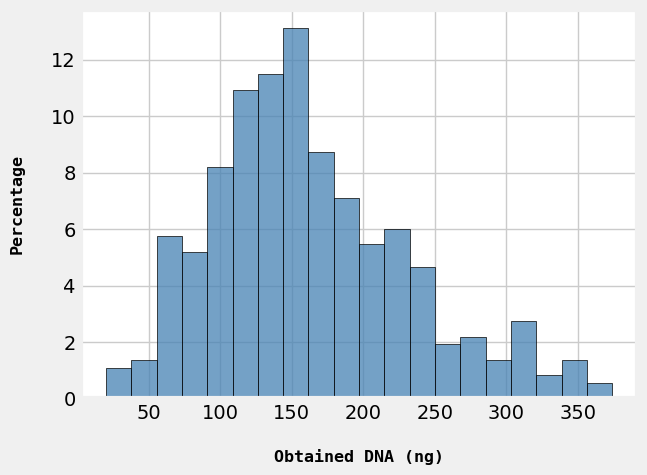

In [13]:
#calculate the extracted DNA for each Ayu sample
ayu[0]["extracted_dna"] = ayu[0]["concentration"] * 20

ax = sns.histplot(x=ayu[0]['extracted_dna'], stat="percent",
             bins = 20, color="steelblue", edgecolor = 'black')

ax.set_facecolor("white")

plt.xlabel('Obtained DNA (ng)', fontsize = 12, 
           fontweight='bold', family='monospace')
plt.ylabel('Percentage', fontsize = 12, 
           fontweight='bold', family='monospace')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')  

ax.xaxis.set_label_coords(.5, -.13)
ax.yaxis.set_label_coords(-.1, .5)

plt.show()

In [14]:
#now move to the sturgeon dataframe, first, check columns contained
st.columns

Index(['experiment_date', 'sample_id', 'combined_id', 'concentration_ng/ul',
       'used_volume', 'lib_id', 'well_letter', 'well_num', 'sample_well',
       'average_size', 'concentration_pg/ul_1:5diluted', 'fs_time', 'input',
       'extract_order', 'note', 'bioanalyzer_range'],
      dtype='object')

In [15]:
#keep needed columns
st_use = st.loc[:,['combined_id', 'average_size','fs_time', 'input']]

#rename columns
st_use.rename({"fs_time":"fragmentation_time", "input":"input_for_lib", 
               "average_size":"size(bp)_TapeStation"}, 
               axis = "columns", inplace = True)

#view head of DataFrame
st_use.head()

,combined_id,size(bp)_TapeStation,fragmentation_time,input_for_lib
2,2022/06/24_03,600.0,3.5,104.0
3,2022/06/24_07,558.0,3.5,108.8
5,2022/06/28_01,591.0,3.5,124.8
6,2022/06/28_02,636.0,3.5,144.0
7,2022/06/28_03,604.0,3.5,140.0


**4. Feature understanding & relationships**<br>
* Plotting feature distributions<br>

    * violin plot<br>

    * histogram<br>

    * scatterplot


In [16]:
#Check relations between fs time and library size.
#First, set groups based on different fragmentation time.

st_use['frag_level'] = pd.cut(st_use["fragmentation_time"], [2,5,10,15], 
                              labels = ["<= 5", "between 5 and 10", "> 10"])

ayu_use['frag_level'] = pd.cut(ayu_use["fragmentation_time"], [2,5,10,35], 
                               labels = ["<= 5", "between 5 and 10", "> 10"])

In [17]:
#combine ayu_use and st_use vertically (along rows)
as_comb = pd.concat([ayu_use, st_use], 
                    keys = ['ayu', 'st']).reset_index()

as_comb.head()

,level_0,level_1,combined_id,size(bp)_TapeStation,fragmentation_time,input_for_lib,frag_level
0,ayu,40,2022/02/24_3,380.0,35.0,127.80,> 10
1,ayu,41,2022/02/24_7,369.0,35.0,157.50,> 10
2,ayu,42,2022/02/24_10,352.0,35.0,122.40,> 10
3,ayu,43,2022/02/24_14,344.0,35.0,137.40,> 10
4,ayu,44,2022/02/24_16,371.0,35.0,146.88,> 10


In [18]:
#Compare distributions of library size between 
#different fragmentation time groups with fixed DNA input for library construction.

as_violin_melt = pd.melt(as_comb.query("90 < input_for_lib <= 130"), id_vars =['frag_level'], 
                         value_vars =["size(bp)_TapeStation"])#i.e., ~ 120ng of input DNA

as_violin_melt.head()

,frag_level,variable,value
0,> 10,size(bp)_TapeStation,380.0
1,> 10,size(bp)_TapeStation,352.0
2,> 10,size(bp)_TapeStation,296.0
3,between 5 and 10,size(bp)_TapeStation,423.0
4,> 10,size(bp)_TapeStation,317.0


**Fig.2 Relation between fragmentation time and library size with fixed input DNA**

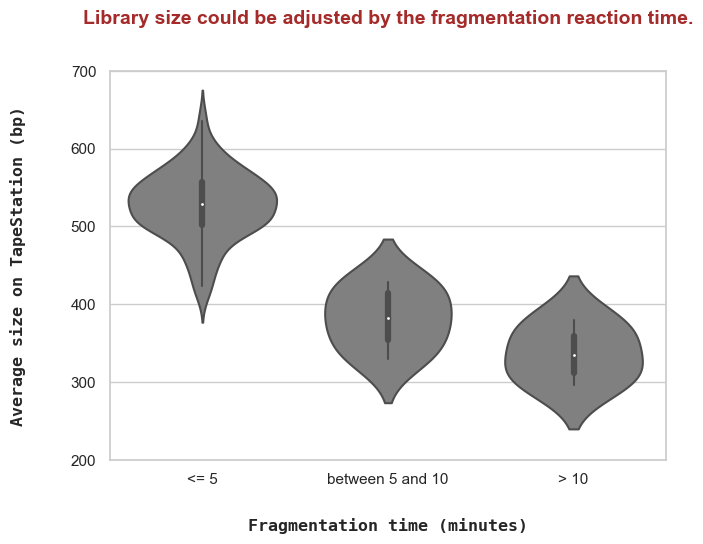

In [19]:
as_violin_melt.rename({"value": "size(bp)"}, axis = "columns", inplace=True)

#Violin-plot
sns.set()
sns.set_style('whitegrid')
sns.set_palette('gray')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.violinplot(x='frag_level', y='size(bp)', data=as_violin_melt, 
               jitter=True, color='gray', ax=ax)

ax.set_xlabel('Fragmentation time (minutes)', fontsize = 12, 
              fontweight='bold', family='monospace')
ax.set_ylabel('Average size on TapeStation (bp)', 
              fontsize = 12, fontweight='bold', family='monospace')
ax.xaxis.set_label_coords(.5, -.15)
ax.yaxis.set_label_coords(-.15, .5)
ax.set_ylim(200, 700)
plt.title("Library size could be adjusted by the fragmentation reaction time.", 
          fontsize=14, fontweight='bold', 
          color = "brown", x=0.5, y=1.1)

plt.show()


**Fig.3 Library size distribution**

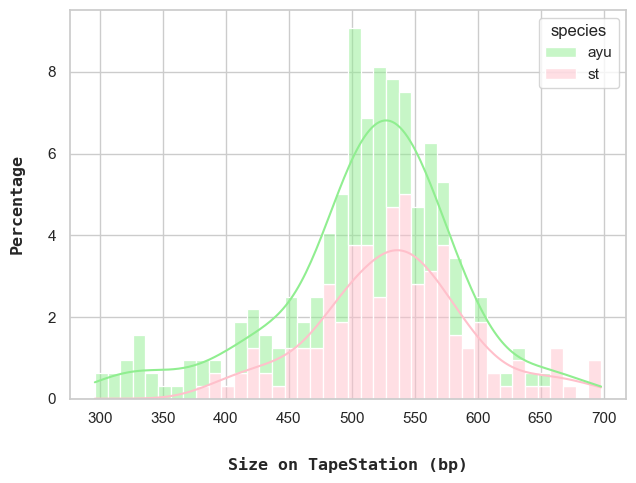

In [21]:
as_comb.rename({"level_0": "species"}, axis = "columns", inplace=True)

ax = sns.histplot(data=as_comb, x="size(bp)_TapeStation", stat="percent",
             bins = 40, hue="species", multiple="stack", 
             palette=['lightgreen', 'pink'],kde=True) 
#'kde=True', add a kernel density estimate to smooth the histogram, 
# providing complementary information about the shape of the distribution

ax.set_xlabel('Size on TapeStation (bp)', fontsize = 12, fontweight='bold', family='monospace')
ax.set_ylabel('Percentage', fontsize = 12, fontweight='bold', family='monospace')

ax.xaxis.set_label_coords(.5, -.15)
ax.yaxis.set_label_coords(-.08, .5)

plt.show()

**Fig.4 Relation between input DNA and library size**

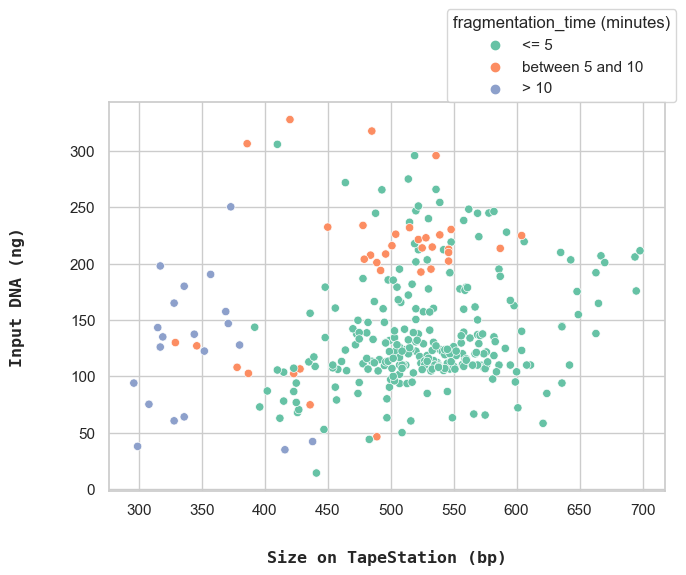

In [22]:
sns.set()
sns.set_style("whitegrid")
sns.set_palette("Set2")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

#Effects of fragmentation time and input DNA amount on yielding libraries.
#create seaborn scatterplot
sns.scatterplot(x='size(bp)_TapeStation',
               y='input_for_lib',
               hue='frag_level',
               data=as_comb, legend='full')

plt.legend(title = "fragmentation_time (minutes)", bbox_to_anchor=(1.02, 1), 
           loc=4, borderaxespad=0)
plt.xlabel('Size on TapeStation (bp)', fontweight='bold',
           fontsize = 12, family='monospace')
plt.ylabel('Input DNA (ng)', fontweight='bold', 
           fontsize = 12, family='monospace')

ax.xaxis.set_label_coords(.5, -.15)
ax.yaxis.set_label_coords(-.15, .5)

plt.show()